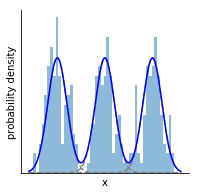

In [81]:
# RJMC for GMMs:
import matplotlib.pyplot as plt
%matplotlib inline

from autograd import numpy as np
np.random.seed(0)
from scipy.stats import norm
from scipy.special import logsumexp

def gaussian_mixture_log_likelihood(X, means, stdevs, weights):
    component_log_pdfs = np.array([norm.logpdf(X, loc=mean, scale=stdev) + np.log(weight) for ((mean, stdev), weight) in zip(zip(means, stdevs), weights)])
    return np.sum(logsumexp(component_log_pdfs, 0))

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

def unpack(theta):
    assert(len(theta) % 2 == 0)
    mid = int(len(theta) / 2)
    means, stdevs = np.array(theta[:mid]), np.array(theta[mid:])
    return means, stdevs

def log_prior(theta):
    means, stdevs = unpack(theta)
    log_prior_on_means = np.sum(norm.logpdf(means, scale=20))
    log_prior_on_variances = np.sum(invgamma.logpdf((stdevs**2), 1.0))
    
    return log_prior_on_means + log_prior_on_variances
    

def flat_log_p(theta):
    """Here we'll fix the weights to be all equal"""
    means, stdevs = unpack(theta)
    if np.min(stdevs) <= 0.01: return - np.inf
    log_likelihood = gaussian_mixture_log_likelihood(X=data, means=means,
                                           stdevs=stdevs,
                                           weights=np.ones(len(means)) / len(means))
    
    return log_likelihood + log_prior(theta)

n_components = 3
true_means = [-5.0,0.0,5.0]
true_stdevs = np.ones(n_components)
n_data = 300
data = np.zeros(n_data)
for i in range(n_data):
    component = np.random.randint(n_components)
    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])

plt.figure(figsize=(3,3))

ax = plt.subplot(111)
    
plt.hist(data, bins=50, normed=True, alpha=0.5);
x = np.linspace(-8,8, 1000)
y_tot = np.zeros(x.shape)
for i in range(n_components):
    
    y = norm.pdf(x, loc=true_means[i], scale=true_stdevs[i]) / n_components
    plt.plot(x,y, '--', color='grey',)
    y_tot += y
plt.plot(x,y_tot, color='blue',)
plt.yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.title("data: {} points sampled from {} mixture components".format(n_data, n_components))
plt.ylabel('probability density')
plt.xlabel('x')
plt.xticks([])
plt.savefig('1-dataset-no-title.jpg', dpi=600, bbox_inches='tight')
plt.savefig('1-dataset-no-title.pdf', dpi=600, bbox_inches='tight')

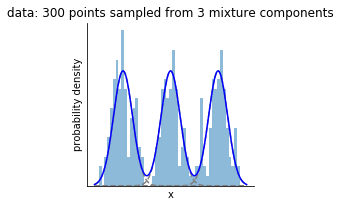

In [80]:
plt.figure(figsize=(3,3))

ax = plt.subplot(111)
    
plt.hist(data, bins=50, normed=True, alpha=0.5);
x = np.linspace(-8,8, 1000)
y_tot = np.zeros(x.shape)
for i in range(n_components):
    
    y = norm.pdf(x, loc=true_means[i], scale=true_stdevs[i]) / n_components
    plt.plot(x,y, '--', color='grey',)
    y_tot += y
plt.plot(x,y_tot, color='blue',)
plt.yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("data: {} points sampled from {} mixture components".format(n_data, n_components))
plt.ylabel('probability density')
plt.xlabel('x')
plt.xticks([])
plt.savefig('1-dataset-with-title.jpg', dpi=600, bbox_inches='tight')
plt.savefig('1-dataset-with-title.jpg', dpi=600, bbox_inches='tight')

In [46]:
from emcee import MHSampler
sampler = MHSampler(cov=np.eye(6) / 3, dim=6, lnprobfn=flat_log_p)

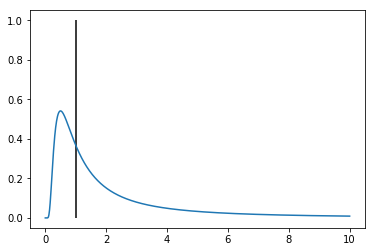

In [47]:
x = np.linspace(1e-4,10,num=1000)
plt.plot(x, np.exp(invgamma.logpdf(x, 1.0)))
plt.vlines(1,0,1)

In [48]:
%%time
result = sampler.run_mcmc(np.random.rand(6), 10000)

CPU times: user 9.07 s, sys: 47.1 ms, total: 9.12 s
Wall time: 9.16 s


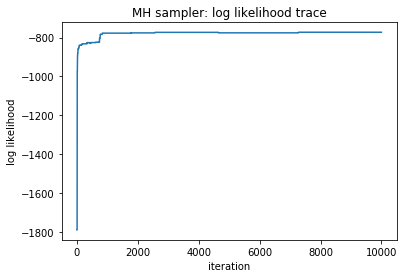

In [49]:
plt.plot(sampler._lnprob.T)
plt.title('MH sampler: log likelihood trace')
plt.xlabel('iteration')
plt.ylabel('log likelihood')

plt.savefig('gmm_likelihood_trace_MH.jpg')

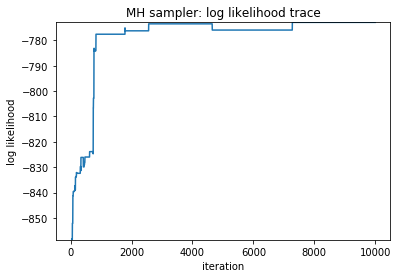

In [50]:
plt.plot(sampler._lnprob.T)

start = 50
#plt.xlim(start, len(sampler._lnprob.T))
plt.ylim(np.min(sampler._lnprob.T[start]), np.max(sampler._lnprob.T))
plt.title('MH sampler: log likelihood trace')
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.savefig('gmm_likelihood_trace_zoomed_in_MH.jpg')

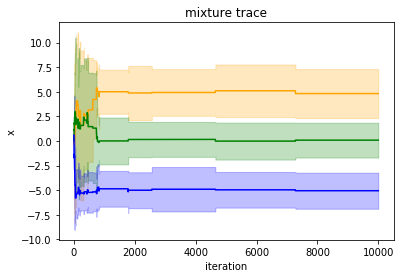

In [51]:
# figure that combines means and stdevs
chain = sampler.chain

colors = ['orange', 'green', 'blue']

for i in range(3):
    mean = chain[:,i]
    stdev = chain[:,i+3]
    color = colors[i]
    
    plt.plot(mean, color=color)
    plt.fill_between(np.arange(len(mean)), mean - 1.96 * stdev, mean + 1.96 * stdev, color=color, alpha=0.25)
plt.ylabel('x')
plt.xlabel('iteration')
plt.title('mixture trace')
plt.savefig('mixture-trace-MH.jpg')

Here we follow Richardson and Green: On Bayesian analysis of mixtures with an unknown number of components (1997)  https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/1467-9868.00095


We'll use a slice of what's described in Richardson / Green... In particular:
* Going to avoid doing anything with latent "allocation" variables z_i describing which mixture component observation i came from...
* Always going to force the weights to be uniform
* Not going to use the hierarchical model
* Not going to bother with smart Gibbs moves

So, to sum up: in section 3.2. we'll only be considering steps (b) and (e), and skipping updates of the weights, allocation, hyperparameter.
* For (b) we'll use basic random-walk Metropolis-Hastings
* For (e) we'll use merge / split moves as described

In [52]:
max_components = 50

def reversible_split_merge_move(theta):
    # unpack means, stdevs, and n_components
    means, stdevs = unpack(theta)
    n_components = len(means)
    
    # decide whether to split or merge
    if n_components == 1:
        split_probability = 1.0
    elif n_components == max_components:
        split_probability = 0.0
    else:
        split_probability = 0.5
    merge_probability = 1.0 - split_probability
    
    if np.random.rand() < split_probability:
        means, stdevs, log_jac_u_term = reversible_split_move(means, stdevs)
    else:
        means, stdevs, log_jac_u_term = reversible_merge_move(means, stdevs)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs)
    return theta_prime, log_jac_u_term
    
from scipy.stats import beta
u_2_distribution = beta(2, 2)
u_3_distribution = beta(1, 1)

def reversible_merge_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    ## pick two adjacent components to merge
    #j1 = np.random.randint(len(means) - 1)
    #j2 = j1 + 1
    
    # pick two random indices
    j1 = np.random.randint(len(means))
    j2 = np.random.randint(len(means))
    while j2 == j1:
        j2 = np.random.randint(len(means))
    
    # ensure j1 < j2
    if j1 > j2:
        j1, j2 = j2, j1
    
    # moment-match proposal
    m_1, m_2 = means[j1], means[j2]
    sigma_1, sigma_2 = stdevs[j1], stdevs[j2]
    new_mean = (m_1 + m_2) / 2
    new_stdev = np.sqrt(m_1**2 + sigma_1**2 + m_2**2 + sigma_2**2 - (m_1 + m_2)**2)
    
    # remove j1 and j2 from the means and stdevs
    _ = means.pop(j2)
    _ = means.pop(j1)
    _ = stdevs.pop(j2)
    _ = stdevs.pop(j1)
    
    # append the new component to the end of the list
    means.append(new_mean)
    stdevs.append(new_stdev)
    
    # Compute u_2, u_3, and jacobian
    # compute u_2 and u_3 that invert the transformation
    u_2 = (new_mean - m_1) / new_stdev
    k = len(means)
    u_3 = 1 - (sigma_2**2 / ((1 - (u_2**2)) * (new_stdev**2) * ((k + 1.0) / k)))
    
    #u_2, u_3 = 0, 0 # invert of the forward transformation
    #log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    jacobian_inv = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * new_stdev**2)
    log_jacobian_inv = np.log(jacobian_inv)
    log_jacobian = - log_jacobian_inv
    #log_jac_u_term = log_jacobian - log_prob_u
    log_jac_u_term = log_jacobian
    
    ## keep it sorted
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    return means, stdevs, log_jac_u_term

def reversible_split_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    # u_1 not needed since no randomness in the weights
    ##u_1 = np.random.beta(2,2)
    
    # select a component at random
    j_star = np.random.randint(len(means))
    m_star = means[j_star]
    sigma_star = stdevs[j_star]
    
    # draw the dimension-matching variables
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # deterministic transformation

    # set means
    m_1 = m_star - (u_2 * sigma_star)
    m_2 = m_star + (u_2 * sigma_star)

    # set stdevs
    k = len(means)
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    
    # log-jacobian: from last line of equation 11 in Richardson and green
    jacobian = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * sigma_star**2)
    log_jacobian = np.log(jacobian)
    
    # log probability of the random numbers we drew
    log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # remove the split component from the means and stdevs
    _ = means.pop(j_star)
    _ = stdevs.pop(j_star)
    
    # append the new components to the means and stdevs
    means.append(m_1)
    means.append(m_2)
    stdevs.append(sigma_1)
    stdevs.append(sigma_2)
    
    return means, stdevs, log_jacobian - log_prob_u

from tqdm import tqdm
def rjmcmc(theta, n_steps=10000):
    
    traj = [theta]
    old_log_p = flat_log_p(theta)
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.1:
            theta_prime, log_jac_u_term = reversible_split_merge_move(theta)
        else:
            theta_prime = theta + np.random.randn(len(theta)) * 0.1
            log_jac_u_term = 0.0
           
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        #log_prob_ratio = (flat_log_p(theta_prime) - flat_log_p(theta))
        if not np.isfinite(new_log_p):
            A = 0
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            old_log_p = new_log_p
            if len(theta) != len(traj[-1]):
                prev_dim = int(len(traj[-1]) / 2)
                current_dim = int(len(theta) / 2)
                assert(len(theta) % 2 == 0)

                print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append(theta)
    return traj

In [53]:
def compute_transformation_and_jacobian_manually(u_2, u_3, m_star, sigma_star, k):
    
    # set means
    m_1 = m_star - (u_2 * sigma_star)
    m_2 = m_star + (u_2 * sigma_star)

    # set stdevs
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    
    # log-jacobian: from last line of equation 11 in Richardson and green
    jacobian = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * sigma_star**2)
    log_jacobian = np.log(jacobian)
    
    return (m_1, sigma_1, m_2, sigma_2), log_jacobian

from autograd import grad

from autograd import numpy as np

def compute_m1(u_2, u_3, m_star, sigma_star, k):
    m_1 = m_star - (u_2 * sigma_star)
    return m_1

def compute_m2(u_2, u_3, m_star, sigma_star, k):
    m_2 = m_star + (u_2 * sigma_star)
    return m_2

def compute_sigma_1(u_2, u_3, m_star, sigma_star, k):
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    return sigma_1

def compute_sigma_2(u_2, u_3, m_star, sigma_star, k):
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    return sigma_2

/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


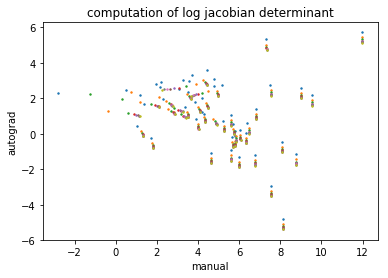

In [54]:
# let's compute the jacobian using autograd

from scipy.stats import beta
u_2_distribution = beta(2, 2)
u_3_distribution = beta(1, 1)


X = []
for _ in range(100):
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    m_star = np.random.randn() * 5
    sigma_star = np.random.rand() * 2
    
    X.append((u_2, u_3, m_star, sigma_star))
    

functions = [compute_m1, compute_m2, compute_sigma_1, compute_sigma_2]

def compute_jacobian(u_2, u_3, m_star, sigma_star, k):
    
    ins = u_2, u_3, m_star, sigma_star
    J = np.zeros((len(ins), len(functions)))
    
    for i in range(len(ins)):
        for j in range(len(functions)):
            J[i, j] = grad(functions[j], argnum=i)(u_2, u_3, m_star, sigma_star, k)
    return J
    

    
for k in range(1,10):
    manual = []
    autogradded = []
    for (u_2, u_3, m_star, sigma_star) in X:
        _, manual_log_jac = compute_transformation_and_jacobian_manually(u_2, u_3, m_star, sigma_star, k)
        manual.append(manual_log_jac)
        
        J = compute_jacobian(u_2, u_3, m_star, sigma_star, k)
        
        autogradded.append(np.log(np.linalg.det(J)))
    plt.scatter(manual, autogradded, s=2)
plt.xlabel('manual')
plt.ylabel('autograd')
plt.title('computation of log jacobian determinant')
        

In [56]:
max_components = 50

def autograd_reversible_split_merge_move(theta):
    # unpack means, stdevs, and n_components
    means, stdevs = unpack(theta)
    n_components = len(means)
    
    # decide whether to split or merge
    if n_components == 1:
        split_probability = 1.0
    elif n_components == max_components:
        split_probability = 0.0
    else:
        split_probability = 0.5
    merge_probability = 1.0 - split_probability
    
    if np.random.rand() < split_probability:
        means, stdevs, log_jac_u_term = autograd_reversible_split_move(means, stdevs)
    else:
        means, stdevs, log_jac_u_term = autograd_reversible_merge_move(means, stdevs)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs)
    return theta_prime, log_jac_u_term
    
from scipy.stats import beta
u_2_distribution = beta(2, 2)
u_3_distribution = beta(1, 1)

def autograd_reversible_merge_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    ## pick two adjacent components to merge
    #j1 = np.random.randint(len(means) - 1)
    #j2 = j1 + 1
    
    # pick two random indices
    j1 = np.random.randint(len(means))
    j2 = np.random.randint(len(means))
    while j2 == j1:
        j2 = np.random.randint(len(means))
    
    # ensure j1 < j2
    if j1 > j2:
        j1, j2 = j2, j1
    
    # moment-match proposal
    m_1, m_2 = means[j1], means[j2]
    sigma_1, sigma_2 = stdevs[j1], stdevs[j2]
    m_star = (m_1 + m_2) / 2
    sigma_star = np.sqrt(m_1**2 + sigma_1**2 + m_2**2 + sigma_2**2 - (m_1 + m_2)**2)
    
    # remove j1 and j2 from the means and stdevs
    _ = means.pop(j2)
    _ = means.pop(j1)
    _ = stdevs.pop(j2)
    _ = stdevs.pop(j1)
    
    # append the new component to the end of the list
    means.append(m_star)
    stdevs.append(sigma_star)
    
    # Compute u_2, u_3, and jacobian
    # compute u_2 and u_3 that invert the transformation
    u_2 = (m_star - m_1) / sigma_star
    k = len(means)
    u_3 = 1 - (sigma_2**2 / ((1 - (u_2**2)) * (sigma_star**2) * ((k + 1.0) / k)))
    
    #u_2, u_3 = 0, 0 # invert of the forward transformation
    log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    log_jacobian = - np.log(np.linalg.det(compute_jacobian(u_2, u_3, m_star, sigma_star, k)))
    log_jac_u_term = log_jacobian
    
    ## keep it sorted
    #inds = np.argsort(means)
    #means = [means[i] for i in inds]
    #stdevs = [stdevs[i] for i in inds]
    
    return means, stdevs, log_jac_u_term

def autograd_reversible_split_move(means, stdevs):
    means = list(means)
    stdevs = list(stdevs)
    
    # u_1 not needed since no randomness in the weights
    ##u_1 = np.random.beta(2,2)
    
    # select a component at random
    j_star = np.random.randint(len(means))
    m_star = means[j_star]
    sigma_star = stdevs[j_star]
    
    # draw the dimension-matching variables
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # deterministic transformation

    # set means
    m_1 = m_star - (u_2 * sigma_star)
    m_2 = m_star + (u_2 * sigma_star)

    # set stdevs
    k = len(means)
    w_1 = w_2 = 1.0 / (1 + k)
    w_star = 1.0 / k
    sigma_1 = np.sqrt(u_3 * (1 - u_2**2) * sigma_star**2 * (w_star / w_1))
    sigma_2 = np.sqrt((1 - u_3) * (1 - u_2**2) * sigma_star**2 * (w_star / w_2))
    
    # log-jacobian: from last line of equation 11 in Richardson and green
    #jacobian = (m_1 - m_2 * sigma_1**2 * sigma_2**2) / (u_2 * (1 - u_2**2) * u_3 * (1 - u_3) * sigma_star**2)
    #log_jacobian = np.log(jacobian)
    log_jacobian = np.log(np.linalg.det(compute_jacobian(u_2, u_3, m_star, sigma_star, k)))
    
    # log probability of the random numbers we drew
    log_prob_u = u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # remove the split component from the means and stdevs
    _ = means.pop(j_star)
    _ = stdevs.pop(j_star)
    
    # append the new components to the means and stdevs
    means.append(m_1)
    means.append(m_2)
    stdevs.append(sigma_1)
    stdevs.append(sigma_2)
    
    return means, stdevs, log_jacobian - log_prob_u

from tqdm import tqdm
def autograd_rjmcmc(theta, n_steps=10000):
    
    traj = [theta]
    old_log_p = flat_log_p(theta)
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.1:
            theta_prime, log_jac_u_term = autograd_reversible_split_merge_move(theta)
        else:
            theta_prime = theta + np.random.randn(len(theta)) * 0.1
            log_jac_u_term = 0.0
           
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        #log_prob_ratio = (flat_log_p(theta_prime) - flat_log_p(theta))
        if not np.isfinite(new_log_p):
            A = 0
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            old_log_p = new_log_p
            if len(theta) != len(traj[-1]):
                prev_dim = int(len(traj[-1]) / 2)
                current_dim = int(len(theta) / 2)
                assert(len(theta) % 2 == 0)

                print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append(theta)
    return traj

In [57]:
np.random.seed(100)
init_n_components = 1
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_theta = np.hstack([init_means, init_stdevs])
traj = autograd_rjmcmc(init_theta, n_steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
  1%|▏         | 133/10000 [00:00<00:07, 1326.63it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
  2%|▏         | 240/10000 [00:00<00:07, 1235.38it/s]

88: accepted a cross-model jump! # components: 1 --> 2
163: accepted a cross-model jump! # components: 2 --> 3
211: accepted a cross-model jump! # components: 3 --> 2


  5%|▌         | 541/10000 [00:00<00:08, 1066.67it/s]

343: accepted a cross-model jump! # components: 2 --> 3
372: accepted a cross-model jump! # components: 3 --> 2
538: accepted a cross-model jump! # components: 2 --> 3


  6%|▋         | 630/10000 [00:00<00:09, 1004.89it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
  7%|▋         | 717/10000 [0

555: accepted a cross-model jump! # components: 3 --> 4
582: accepted a cross-model jump! # components: 4 --> 3
585: accepted a cross-model jump! # components: 3 --> 4
599: accepted a cross-model jump! # components: 4 --> 3
631: accepted a cross-model jump! # components: 3 --> 4
653: accepted a cross-model jump! # components: 4 --> 5
686: accepted a cross-model jump! # components: 5 --> 4
715: accepted a cross-model jump! # components: 4 --> 3


  9%|▉         | 921/10000 [00:00<00:09, 947.73it/s]

756: accepted a cross-model jump! # components: 3 --> 2
769: accepted a cross-model jump! # components: 2 --> 1
807: accepted a cross-model jump! # components: 1 --> 2
811: accepted a cross-model jump! # components: 2 --> 3
820: accepted a cross-model jump! # components: 3 --> 2
821: accepted a cross-model jump! # components: 2 --> 3


 12%|█▏        | 1227/10000 [00:01<00:08, 977.07it/s]

1053: accepted a cross-model jump! # components: 3 --> 2
1058: accepted a cross-model jump! # components: 2 --> 1
1093: accepted a cross-model jump! # components: 1 --> 2


 14%|█▍        | 1446/10000 [00:01<00:08, 1026.45it/s]

1336: accepted a cross-model jump! # components: 2 --> 3
1397: accepted a cross-model jump! # components: 3 --> 2
1462: accepted a cross-model jump! # components: 2 --> 3


 19%|█▊        | 1851/10000 [00:01<00:08, 982.20it/s] 

1652: accepted a cross-model jump! # components: 3 --> 2
1733: accepted a cross-model jump! # components: 2 --> 3
1817: accepted a cross-model jump! # components: 3 --> 2


 22%|██▏       | 2182/10000 [00:02<00:08, 909.20it/s] 

2038: accepted a cross-model jump! # components: 2 --> 3
2099: accepted a cross-model jump! # components: 3 --> 4
2149: accepted a cross-model jump! # components: 4 --> 3
2157: accepted a cross-model jump! # components: 3 --> 4
2163: accepted a cross-model jump! # components: 4 --> 3


 23%|██▎       | 2277/10000 [00:02<00:09, 849.56it/s]

2201: accepted a cross-model jump! # components: 3 --> 4
2214: accepted a cross-model jump! # components: 4 --> 5
2260: accepted a cross-model jump! # components: 5 --> 4


 25%|██▌       | 2534/10000 [00:02<00:09, 771.71it/s]

2426: accepted a cross-model jump! # components: 4 --> 5
2431: accepted a cross-model jump! # components: 5 --> 6
2463: accepted a cross-model jump! # components: 6 --> 5
2547: accepted a cross-model jump! # components: 5 --> 4
2572: accepted a cross-model jump! # components: 4 --> 5


 27%|██▋       | 2689/10000 [00:02<00:10, 699.19it/s]

2579: accepted a cross-model jump! # components: 5 --> 6
2582: accepted a cross-model jump! # components: 6 --> 7
2678: accepted a cross-model jump! # components: 7 --> 6


 28%|██▊       | 2836/10000 [00:03<00:10, 703.96it/s]

2734: accepted a cross-model jump! # components: 6 --> 5
2847: accepted a cross-model jump! # components: 5 --> 4


 32%|███▏      | 3162/10000 [00:03<00:08, 764.58it/s]

3005: accepted a cross-model jump! # components: 4 --> 5
3050: accepted a cross-model jump! # components: 5 --> 4


 33%|███▎      | 3317/10000 [00:03<00:09, 741.88it/s]

3230: accepted a cross-model jump! # components: 4 --> 5
3306: accepted a cross-model jump! # components: 5 --> 4
3323: accepted a cross-model jump! # components: 4 --> 3
3352: accepted a cross-model jump! # components: 3 --> 2


 36%|███▌      | 3579/10000 [00:04<00:07, 813.13it/s]

3436: accepted a cross-model jump! # components: 2 --> 3
3453: accepted a cross-model jump! # components: 3 --> 4
3556: accepted a cross-model jump! # components: 4 --> 3
3577: accepted a cross-model jump! # components: 3 --> 4


 37%|███▋      | 3749/10000 [00:04<00:08, 759.69it/s]

3666: accepted a cross-model jump! # components: 4 --> 5


 40%|███▉      | 3975/10000 [00:04<00:08, 685.69it/s]

3880: accepted a cross-model jump! # components: 5 --> 4
3912: accepted a cross-model jump! # components: 4 --> 3
3950: accepted a cross-model jump! # components: 3 --> 2
4025: accepted a cross-model jump! # components: 2 --> 3


 43%|████▎     | 4331/10000 [00:05<00:06, 816.87it/s]

4162: accepted a cross-model jump! # components: 3 --> 2
4286: accepted a cross-model jump! # components: 2 --> 3
4292: accepted a cross-model jump! # components: 3 --> 4


 45%|████▍     | 4493/10000 [00:05<00:07, 746.13it/s]

4395: accepted a cross-model jump! # components: 4 --> 3
4397: accepted a cross-model jump! # components: 3 --> 2
4437: accepted a cross-model jump! # components: 2 --> 3
4482: accepted a cross-model jump! # components: 3 --> 4


 48%|████▊     | 4754/10000 [00:05<00:06, 827.55it/s]

4609: accepted a cross-model jump! # components: 4 --> 3


 50%|████▉     | 4955/10000 [00:05<00:05, 910.71it/s]

4850: accepted a cross-model jump! # components: 3 --> 2
4966: accepted a cross-model jump! # components: 2 --> 3
4990: accepted a cross-model jump! # components: 3 --> 2


 51%|█████▏    | 5139/10000 [00:06<00:06, 806.90it/s]

5067: accepted a cross-model jump! # components: 2 --> 3
5074: accepted a cross-model jump! # components: 3 --> 2
5128: accepted a cross-model jump! # components: 2 --> 3
5133: accepted a cross-model jump! # components: 3 --> 4
5152: accepted a cross-model jump! # components: 4 --> 3


 53%|█████▎    | 5321/10000 [00:06<00:05, 803.32it/s]

5253: accepted a cross-model jump! # components: 3 --> 2
5255: accepted a cross-model jump! # components: 2 --> 1
5258: accepted a cross-model jump! # components: 1 --> 2
5311: accepted a cross-model jump! # components: 2 --> 3
5344: accepted a cross-model jump! # components: 3 --> 4


 56%|█████▌    | 5595/10000 [00:06<00:05, 867.28it/s]

5431: accepted a cross-model jump! # components: 4 --> 3
5589: accepted a cross-model jump! # components: 3 --> 2


 58%|█████▊    | 5803/10000 [00:06<00:04, 940.22it/s]

5661: accepted a cross-model jump! # components: 2 --> 3
5816: accepted a cross-model jump! # components: 3 --> 2
5820: accepted a cross-model jump! # components: 2 --> 1


 60%|██████    | 6000/10000 [00:06<00:04, 942.45it/s]

5874: accepted a cross-model jump! # components: 1 --> 2


 62%|██████▏   | 6206/10000 [00:07<00:03, 955.55it/s]

6106: accepted a cross-model jump! # components: 2 --> 3
6110: accepted a cross-model jump! # components: 3 --> 4
6257: accepted a cross-model jump! # components: 4 --> 3


 66%|██████▌   | 6573/10000 [00:07<00:04, 815.52it/s]

6425: accepted a cross-model jump! # components: 3 --> 4
6472: accepted a cross-model jump! # components: 4 --> 3
6491: accepted a cross-model jump! # components: 3 --> 4


 67%|██████▋   | 6739/10000 [00:07<00:04, 814.60it/s]

6664: accepted a cross-model jump! # components: 4 --> 3
6694: accepted a cross-model jump! # components: 3 --> 4
6752: accepted a cross-model jump! # components: 4 --> 3


 70%|██████▉   | 6989/10000 [00:08<00:03, 789.85it/s]

6848: accepted a cross-model jump! # components: 3 --> 4


 73%|███████▎  | 7270/10000 [00:08<00:03, 880.01it/s]

7082: accepted a cross-model jump! # components: 4 --> 3


 75%|███████▍  | 7455/10000 [00:08<00:02, 902.83it/s]

7321: accepted a cross-model jump! # components: 3 --> 2
7372: accepted a cross-model jump! # components: 2 --> 3
7434: accepted a cross-model jump! # components: 3 --> 2
7498: accepted a cross-model jump! # components: 2 --> 3


 77%|███████▋  | 7683/10000 [00:08<00:02, 1006.80it/s]

7552: accepted a cross-model jump! # components: 3 --> 2
7562: accepted a cross-model jump! # components: 2 --> 1
7617: accepted a cross-model jump! # components: 1 --> 2
7660: accepted a cross-model jump! # components: 2 --> 3
7766: accepted a cross-model jump! # components: 3 --> 2


/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
 79%|███████▉  | 7885/10000 [00:09<00:02, 961.22it/s] 

7773: accepted a cross-model jump! # components: 2 --> 1
7784: accepted a cross-model jump! # components: 1 --> 2
7792: accepted a cross-model jump! # components: 2 --> 3
7892: accepted a cross-model jump! # components: 3 --> 4


 83%|████████▎ | 8305/10000 [00:09<00:01, 986.90it/s]

8079: accepted a cross-model jump! # components: 4 --> 3
8088: accepted a cross-model jump! # components: 3 --> 2
8100: accepted a cross-model jump! # components: 2 --> 1
8171: accepted a cross-model jump! # components: 1 --> 2
8262: accepted a cross-model jump! # components: 2 --> 3


 85%|████████▌ | 8546/10000 [00:09<00:01, 1088.67it/s]

8325: accepted a cross-model jump! # components: 3 --> 2
8545: accepted a cross-model jump! # components: 2 --> 3


 88%|████████▊ | 8775/10000 [00:09<00:01, 1061.44it/s]

8617: accepted a cross-model jump! # components: 3 --> 2
8674: accepted a cross-model jump! # components: 2 --> 3
8719: accepted a cross-model jump! # components: 3 --> 2
8722: accepted a cross-model jump! # components: 2 --> 3
8730: accepted a cross-model jump! # components: 3 --> 2


 91%|█████████ | 9107/10000 [00:10<00:00, 1015.70it/s]

9022: accepted a cross-model jump! # components: 2 --> 3
9044: accepted a cross-model jump! # components: 3 --> 4
9137: accepted a cross-model jump! # components: 4 --> 3


 93%|█████████▎| 9308/10000 [00:10<00:00, 908.27it/s] 

9208: accepted a cross-model jump! # components: 3 --> 4


 96%|█████████▌| 9592/10000 [00:10<00:00, 864.49it/s]

9430: accepted a cross-model jump! # components: 4 --> 3
9500: accepted a cross-model jump! # components: 3 --> 4
9581: accepted a cross-model jump! # components: 4 --> 3


 98%|█████████▊| 9789/10000 [00:11<00:00, 919.64it/s]

9688: accepted a cross-model jump! # components: 3 --> 4


100%|██████████| 10000/10000 [00:11<00:00, 883.00it/s]


In [58]:
n_components_traj = [int(len(theta) / 2) for theta in traj]

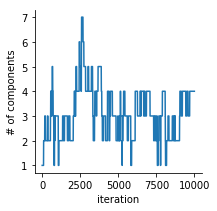

In [82]:
plt.figure(figsize=(3,3))
ax = plt.subplot(111)
plt.plot(n_components_traj)
plt.xlabel('iteration')
plt.ylabel('# of components')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('rjmc-component-trace.jpg', dpi=600, bbox_inches='tight')
plt.savefig('rjmc-component-trace.pdf', dpi=600, bbox_inches='tight')

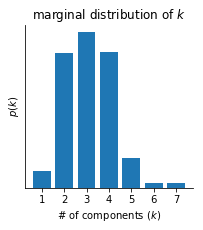

In [83]:
plt.figure(figsize=(3,3))
n_components_range = sorted(list(set(n_components_traj)))
counts = np.bincount(n_components_traj)[1:]
ax = plt.subplot(111)

plt.bar(n_components_range, counts / sum(counts))
plt.xlabel(r'# of components ($k$)')
plt.ylabel(r'$p(k)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'marginal distribution of $k$')
plt.xticks(n_components_range)
plt.yticks([])
plt.savefig('3-marginals-with-title.jpg', dpi=600, bbox_inches='tight')
plt.savefig('3-marginals-with-title.pdf', dpi=600, bbox_inches='tight')

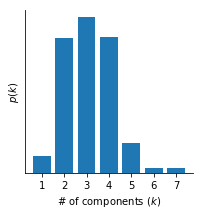

In [84]:
plt.figure(figsize=(3,3))
n_components_range = sorted(list(set(n_components_traj)))
counts = np.bincount(n_components_traj)[1:]
ax = plt.subplot(111)

plt.bar(n_components_range, counts / sum(counts))
plt.xlabel(r'# of components ($k$)')
plt.ylabel(r'$p(k)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.title(r'marginal distribution of $k$')
plt.xticks(n_components_range)
plt.yticks([])
plt.savefig('3-marginals-no-title.jpg', dpi=600, bbox_inches='tight')
plt.savefig('3-marginals-no-title.pdf', dpi=600, bbox_inches='tight')

In [85]:
counts

array([ 356, 2797, 3217, 2821,  623,   91,   96])

In [86]:
change_points = list(np.arange(1, len(n_components_traj))[np.diff(n_components_traj) != 0])
print(change_points)

[89, 164, 212, 344, 373, 539, 556, 583, 586, 600, 632, 654, 687, 716, 757, 770, 808, 812, 821, 822, 1054, 1059, 1094, 1337, 1398, 1463, 1653, 1734, 1818, 2039, 2100, 2150, 2158, 2164, 2202, 2215, 2261, 2427, 2432, 2464, 2548, 2573, 2580, 2583, 2679, 2735, 2848, 3006, 3051, 3231, 3307, 3324, 3353, 3437, 3454, 3557, 3578, 3667, 3881, 3913, 3951, 4026, 4163, 4287, 4293, 4396, 4398, 4438, 4483, 4610, 4851, 4967, 4991, 5068, 5075, 5129, 5134, 5153, 5254, 5256, 5259, 5312, 5345, 5432, 5590, 5662, 5817, 5821, 5875, 6107, 6111, 6258, 6426, 6473, 6492, 6665, 6695, 6753, 6849, 7083, 7322, 7373, 7435, 7499, 7553, 7563, 7618, 7661, 7767, 7774, 7785, 7793, 7893, 8080, 8089, 8101, 8172, 8263, 8326, 8546, 8618, 8675, 8720, 8723, 8731, 9023, 9045, 9138, 9209, 9431, 9501, 9582, 9689]


In [87]:
trajs = []
for (start, end) in list(zip([0] + change_points, change_points + [len(traj)])):
    trajs.append(np.array(traj[start:end]))
    print(trajs[-1].shape)

(89, 2)
(75, 4)
(48, 6)
(132, 4)
(29, 6)
(166, 4)
(17, 6)
(27, 8)
(3, 6)
(14, 8)
(32, 6)
(22, 8)
(33, 10)
(29, 8)
(41, 6)
(13, 4)
(38, 2)
(4, 4)
(9, 6)
(1, 4)
(232, 6)
(5, 4)
(35, 2)
(243, 4)
(61, 6)
(65, 4)
(190, 6)
(81, 4)
(84, 6)
(221, 4)
(61, 6)
(50, 8)
(8, 6)
(6, 8)
(38, 6)
(13, 8)
(46, 10)
(166, 8)
(5, 10)
(32, 12)
(84, 10)
(25, 8)
(7, 10)
(3, 12)
(96, 14)
(56, 12)
(113, 10)
(158, 8)
(45, 10)
(180, 8)
(76, 10)
(17, 8)
(29, 6)
(84, 4)
(17, 6)
(103, 8)
(21, 6)
(89, 8)
(214, 10)
(32, 8)
(38, 6)
(75, 4)
(137, 6)
(124, 4)
(6, 6)
(103, 8)
(2, 6)
(40, 4)
(45, 6)
(127, 8)
(241, 6)
(116, 4)
(24, 6)
(77, 4)
(7, 6)
(54, 4)
(5, 6)
(19, 8)
(101, 6)
(2, 4)
(3, 2)
(53, 4)
(33, 6)
(87, 8)
(158, 6)
(72, 4)
(155, 6)
(4, 4)
(54, 2)
(232, 4)
(4, 6)
(147, 8)
(168, 6)
(47, 8)
(19, 6)
(173, 8)
(30, 6)
(58, 8)
(96, 6)
(234, 8)
(239, 6)
(51, 4)
(62, 6)
(64, 4)
(54, 6)
(10, 4)
(55, 2)
(43, 4)
(106, 6)
(7, 4)
(11, 2)
(8, 4)
(100, 6)
(187, 8)
(9, 6)
(12, 4)
(71, 2)
(91, 4)
(63, 6)
(220, 4)
(72, 6)
(57, 4)
(

In [88]:
trajs[1]

array([[-2.3010962 ,  1.57292787,  2.82169626,  3.27746064],
       [-2.3010962 ,  1.57292787,  2.82169626,  3.27746064],
       [-2.33455632,  1.45660428,  2.81957869,  3.31056781],
       [-2.33455632,  1.45660428,  2.81957869,  3.31056781],
       [-2.33455632,  1.45660428,  2.81957869,  3.31056781],
       [-2.52454299,  1.4017689 ,  2.67311488,  3.51408516],
       [-2.61301333,  1.3055015 ,  2.6400122 ,  3.60910466],
       [-2.57986807,  1.29631368,  2.68541174,  3.58641348],
       [-2.56127178,  1.2795065 ,  2.77459001,  3.68463796],
       [-2.56127178,  1.2795065 ,  2.77459001,  3.68463796],
       [-2.673865  ,  1.44232572,  2.87235841,  3.70143777],
       [-2.67346803,  1.48792969,  2.77241232,  3.71899546],
       [-2.75574388,  1.55750073,  2.86129115,  3.7655916 ],
       [-2.77678733,  1.54609219,  2.78888011,  3.67012386],
       [-2.76464487,  1.59486042,  2.8956048 ,  3.51077225],
       [-2.76464487,  1.59486042,  2.8956048 ,  3.51077225],
       [-2.66782153,  1.

100%|██████████| 134/134 [00:00<00:00, 314.73it/s]


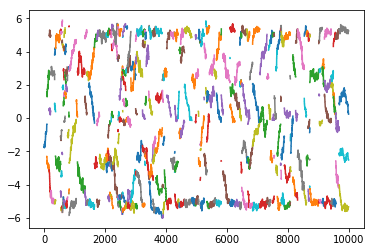

In [72]:
for i in tqdm(range(len(trajs))):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components])

(0, 1000)

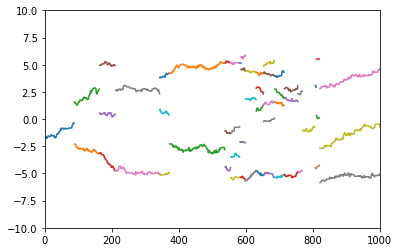

In [73]:
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components])
plt.ylim(-10,10)
plt.xlim(0,1000)

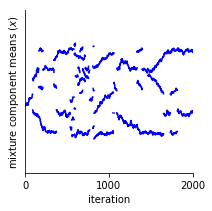

In [91]:
plt.figure(figsize=(3,3))
ax = plt.subplot(111)
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components], color='blue')
plt.ylim(-10,10)
plt.xlim(0,2000)
#plt.yticks([-10,0,10])
plt.yticks([])
plt.xticks([0,1000, 2000])
plt.xlabel('iteration')
plt.ylabel(r'mixture component means ($x$)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('2-branching.jpg', dpi=600, bbox_inches='tight')
plt.savefig('2-branching.pdf', dpi=600, bbox_inches='tight')

In [ ]:
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,n_components:])

In [ ]:
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,n_components:])
plt.yscale('log')
plt.ylabel('component variance')
plt.xlabel('iteration')
plt.savefig('rjmc-component-variance.jpg')

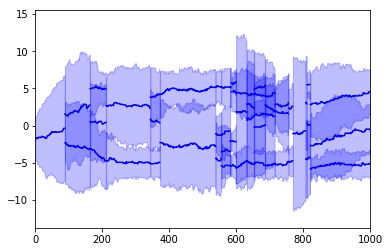

In [249]:
colors = ['blue'] * max_components
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    
    t = trajs[i]
    
    for j in range(n_components):
        mean = t[:,j]
        stdev = t[:,j + n_components]
        color = colors[j]

        plt.plot(np.arange(x_init, x_end), mean, color=color)
        plt.fill_between(np.arange(x_init, x_end), mean - 1.96 * stdev, mean + 1.96 * stdev, color=color, alpha=0.25)
        
    plt.xlim(0,1000)

In [250]:
x_end

10001

In [253]:
snapshots = dict()

for k in n_components_range:
    snapshots[k] = np.vstack([theta for theta in traj if len(theta) == (2 * k)])

In [29]:
from seaborn.apionly import color_palette

max_n_components = max([int(t.shape[1] / 2) for t in trajs])
colors = color_palette('pastel', max_n_components)

for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 2)
    
    t = trajs[i]
    
    
    for j in range(n_components):
        mean = t[:,j]
        stdev = t[:,j + n_components]
        color = colors[j]
    
        plt.plot(mean, color=color)
        plt.fill_between(np.arange(len(mean)), mean - 1.96 * stdev, mean + 1.96 * stdev, color=color, alpha=0.5 / n_components)
plt.xscale('log')

NameError: name 'trajs' is not defined

In [32]:
log_prior_trace = [log_prior(theta) for theta in tqdm(traj)]

100%|██████████| 10001/10001 [00:02<00:00, 3689.17it/s]


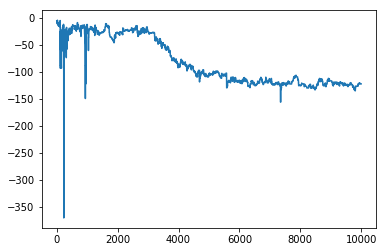

In [33]:
plt.plot(log_prior_trace)

In [34]:
log_prior_trace[20]

-4.650508027621516

In [35]:
log_prob_trace = [flat_log_p(theta) for theta in tqdm(traj)]

100%|██████████| 10001/10001 [00:42<00:00, 158.59it/s]


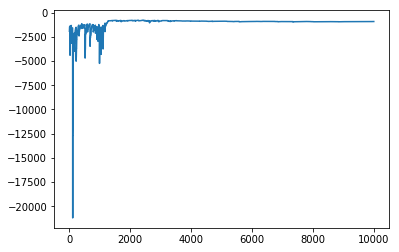

In [36]:
plt.plot(log_prob_trace)

(-1260.4359137375473, -780.5853294990308)

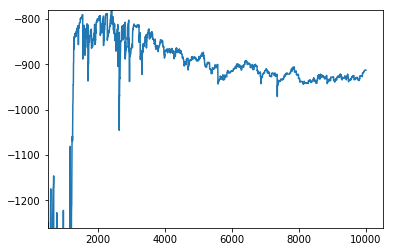

In [37]:
plt.plot(log_prob_trace)
plt.xlim(500,)
plt.ylim(log_prob_trace[500],max(log_prob_trace))

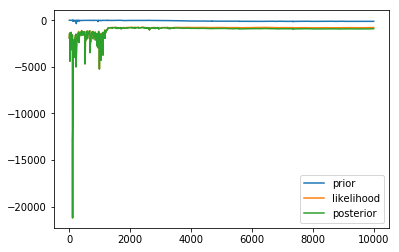

In [38]:
plt.plot(np.array(log_prior_trace), label='prior')
plt.plot(np.array(log_prob_trace) - np.array(log_prior_trace), label='likelihood')
plt.plot(np.array(log_prob_trace), label='posterior')
plt.legend(loc='best')

plt.savefig('rjmc-trace.jpg')

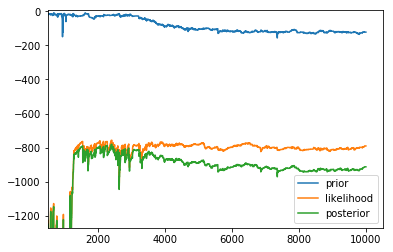

In [39]:
plt.plot(np.array(log_prior_trace), label='prior')
plt.plot(np.array(log_prob_trace) - np.array(log_prior_trace), label='likelihood')
plt.plot(np.array(log_prob_trace), label='posterior')
plt.legend(loc='best')

plt.xlim(500,)
plt.ylim(log_prob_trace[500] - 10, max(log_prior_trace) + 10)

plt.savefig('rjmc-trace-zoomed.jpg')